# CQF Exam Two

## January 2024 Cohort

## Task (copied from the exam sheet, writing $K$ instead of $E$ for the strike)

Use the expected value of the discounted payoff under the risk-neutral density $\mathbb{Q}$

$$
V(S, t) = e^{-r(T-t)} \mathbb{E}^\mathbb{Q}\left[\textbf{Payoff}(S_T)\right]
$$

for the appropriate form of payoff, to consider **Asian** and **Lookback** options.

Use the **Euler-Maruyama** (only) scheme for initially simulating the underlying stock price. As an initial example you may use the following set of sample data:

\begin{align*}
\text{Today's stock price } S_0 & = 100 \\
\text{Strike } K & = 100 \\
\text{Time to expiry } (T - t) & = 1 \text{ year} \\
\text{Volatility } \sigma & = 20\% \\
\text{Constant risk-free interest rate } r & = 5\%
\end{align*}

Then vary the data to see the affect on the option price.

## Solution

### 1 Mathematical formulation

Under risk neutrality, we assume the underlying stock price process $S_t$ follows a Geometric Brownian motion

$$dS_t = rS_t dt + \sigma S_t dW_t,$$

where $S_t$ is the price of the underlying at time $t$, $\sigma$ is constant volatility, $r$ is the constant risk-free interest rate, and $W_t$ is the Brownian motion.

Following the procedures described in [1] + [2], Euler-Maruyama method discretizes the process $S_t$ over the time steps $\delta t$ in the time interval $0 < \delta t < T$ to

$$S(t+\delta t) = S(t) * \left(1+ r\delta t+\sigma  \sqrt{\delta t}\phi\right),$$

where $\phi$ is from a standardized Normal distribution. But since our SDE for the asset path is integrable, we can find the time-stepping algorithm

$$S(t+\delta t) = S(t) * \exp\left[\left(r-\frac{1}{2}\sigma^2\right)\delta t + \sigma\sqrt{\delta t}\phi\right],$$

which is what we will implement in the following.

*Remark*: I shall denote the strike $E$ as $K$ in the following, since this will not interfere with any expected values.

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from scipy.stats import gmean


np.set_printoptions(precision=3)
pd.set_option('display.precision', 4)
warnings.filterwarnings('ignore')

In [87]:
S0 = 100
K = 100  # using K for strike seems more natural for me, so I named this variable K
t = 1
sigma = 0.2
r = 0.05
dt = 0.01
number_of_mc_paths = 50000

### 2 Generate price paths

Now generate $N=50k$ Monte Carlo asset paths using the discretized time-stepping algorithm for Geometric Brownian motion and store these asset simulations in an array S. Each of these 50k simulations of S will contain $(T-t)/0.01 = 100$ stock prices for each time step $\delta t$ over the course of the observation period until the derivative options expire.

It makes sense to have a high number of Monte Carlo paths (in this case: $N=50000$), because the sources in the Monte Carlo pricing method are of order $\mathcal{O}(N^{-0.5})$. The time step size $\delta t$ should also be chosen as small as possible, since the discretization of continuous events always introduces some imprecisions of order $\mathcal{O}(\delta t)$.

In [88]:
def simulate_stock_price(S0, r, sigma, t, dt, number_of_mc_paths=10000):
    """Simulate stock price using Euler-Maruyama method."""
    N = int(t / dt)  # number of time steps
    S = np.zeros((number_of_mc_paths, N))
    S[:, 0] = S0
    for i in range(1, N):
        dW = np.random.standard_normal(number_of_mc_paths)  # Brownian increment
        S[:, i] = S[:, i-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * dW)  # Euler-Maruyama step
    return S


S = simulate_stock_price(S0, r, sigma, t, dt, number_of_mc_paths)
# S is an array with length = <number_of_mc_paths> containing the simulated asset prices
S

array([[100.   , 100.404,  99.287, ...,  85.778,  83.799,  82.186],
       [100.   , 103.058, 103.87 , ..., 108.175, 108.868, 109.102],
       [100.   , 102.856, 103.204, ..., 112.487, 114.638, 116.828],
       ...,
       [100.   , 100.235,  97.542, ...,  96.999,  99.296, 100.383],
       [100.   , 100.819, 101.145, ...,  56.622,  57.862,  57.672],
       [100.   , 101.672, 103.451, ..., 133.133, 137.273, 137.507]])

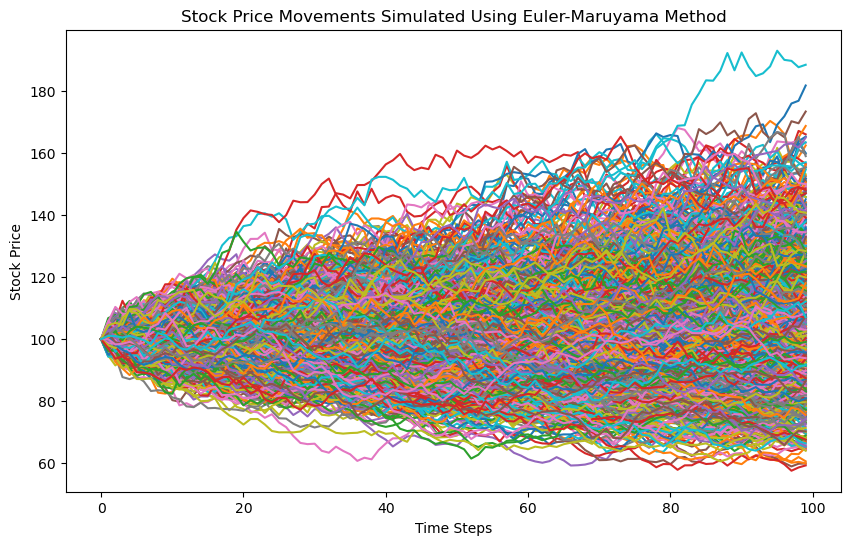

In [89]:
plt.figure(figsize=(10, 6))
for i in range(1000):  # plot the first 1000 paths
    plt.plot(S[i, :])
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('Stock Price Movements Simulated Using Euler-Maruyama Method')
plt.show()

### 3 From asset price to option price

With our asset price simulations generated, we can now calculate the option payoff at expiry, i.e. $\textbf{Payoff}(S_T)$, for every path. This yields $N$ option payoffs for each option type. Under risk-neutral measure $\mathbb{Q}$, the option price at any time $0\leq t\leq T$ is the discounted value of the expected payoff we apply the formula, i.e.

$$V(S, t) = e^{-r(T-t)} \mathbb{E}^\mathbb{Q}\left[\textbf{Payoff}(S_T)\right].$$

We will now implement this formula for **Asian options** and **Lookback options**.

The following follows both Paul's book [3] as well as the Riaz' lecture notes on Exotic Options [4].

##### Asian options
Asian options depend on the average price of the underlying price $S_t$ for $0<t<T$. Denote this average price by $A$. For a fixed strike $K$, the payoff functions are given by
* Asian call payoff = $\max(A-K, 0)$,
* Asian put payoff = $\max(K-A, 0)$.

Asian options with so-called floating strike have payoffs
* Asian call payoff = $\max(S-A, 0)$,
* Asian put payoff = $\max(A-S, 0)$.

The average price over a time interval $[0,T]$ is defined as:
* Continuous average: $$A=\frac{1}{T}\int_0^T S(t) dt,$$
* Discrete average with $0=t_1<...<t_n=T$ with $t_i=i*\delta t$: $$A=\frac{1}{n}\sum_{i=1}^n S(t_i).$$

Since we are discretizing the time interval, we will use the discrete average implementation and any discussion shall regard the discrete functions over the interval $[0,T]$. In fact, infinitesimal implementation is impossible in a real-life situation.
Note that there the described average function is the *arithmetic average*. One could also consider the *geometric average* $A_g$, discretely calculated as: $$A_g=\left(\prod_{i=1}^n S(t_i) \right)^{1/n}$$.

##### Lookback options
Lookback options depend on the maximum price $M$ or minimum price $m$ of the underlying price $S_t$ for $0<t<T$. For a fixed strike $K$, the payoff functions are given by
* Lookback call payoff, fixed strike = $\max(M-K, 0)$
* Lookback put payoff, fixed strike = $\max(K-m, 0)$.

Lookback options with so-called floating strike have payoffs
* Lookback call payoff, floating strike = $\max(S_T-m, 0)=S_T-m$
* Lookback put payoff, floating strike = $\max(M-S_T, 0)=M-S_T$.

In [90]:
def asian_option(S, K, r, t, arithmetic_avg=1, fixed_strike=1):
    """Calculate Asian call + put option prices by discounting their expected payoffs."""
    if arithmetic_avg:  # calculate arithmetic mean stock price over all simulations
        avg = np.mean(S, axis=1)
    else:  # calculate geometric average
        avg = gmean(S, axis=1)
    if fixed_strike:
        asian_call = np.exp(-r * t) * np.maximum(avg - K, 0)
        asian_put = np.exp(-r * t) * np.maximum(K - avg, 0)
    else:  # calculate the option payoffs for floating strike now
        asian_call = np.exp(-r * t) * np.maximum(S[:, -1] - avg, 0)
        asian_put = np.exp(-r * t) * np.maximum(avg - S[:, -1], 0)
    return np.mean(asian_call), np.mean(asian_put)


def lookback_option(S, K, r, t, fixed_strike=1):
    """Calculate Lookback call + put option prices by discounting their expected payoffs."""
    min_S = np.min(S, axis=1)  # minimum stock price over all simulations
    max_S = np.max(S, axis=1)  # maximum stock price over all simulations
    if fixed_strike:
        lookback_call = np.exp(-r * t) * np.maximum(max_S - K, 0)
        lookback_put = np.exp(-r * t) * np.maximum(K - min_S, 0)
    else:  # calculate the option payoffs for floating strike now
        lookback_call = np.exp(-r * t) * np.maximum(S[:, -1] - min_S, 0)
        lookback_put = np.exp(-r * t) * np.maximum(max_S - S[:, -1], 0)
    return np.mean(lookback_call), np.mean(lookback_put)

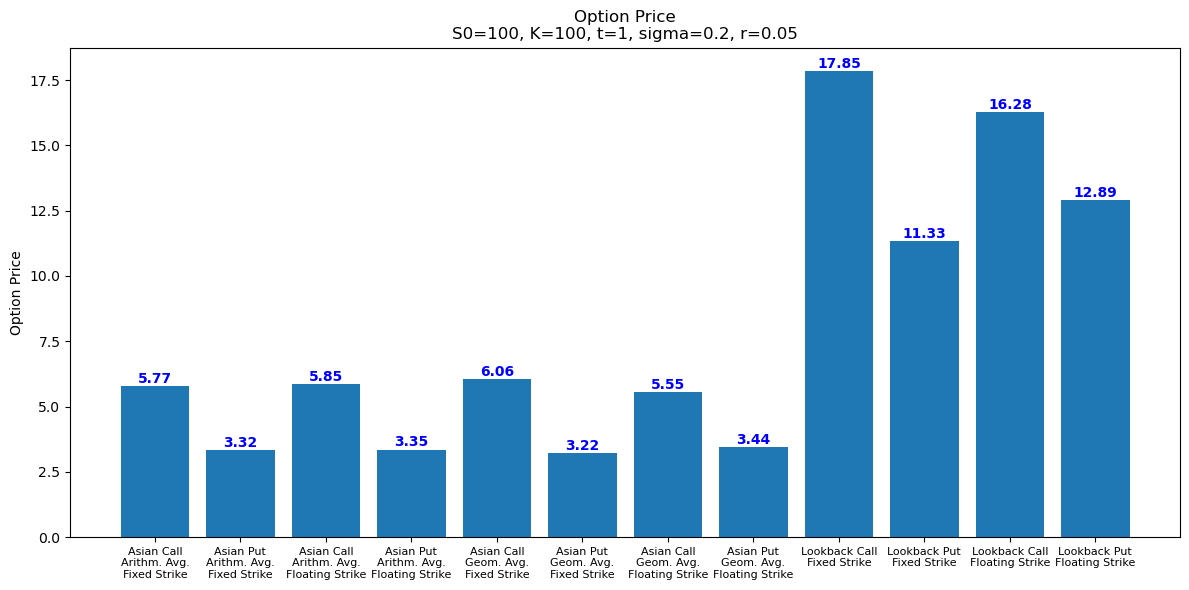

In [91]:
# Calculate option prices + plot them in a bar diagram
asian_fixed_call, asian_fixed_put = asian_option(S, K, r, t, arithmetic_avg=1, fixed_strike=1)
asian_float_call, asian_float_put = asian_option(S, K, r, t, arithmetic_avg=1, fixed_strike=0)
asian_g_fixed_call, asian_g_fixed_put = asian_option(S, K, r, t, arithmetic_avg=0, fixed_strike=0)
asian_g_float_call, asian_g_float_put = asian_option(S, K, r, t, arithmetic_avg=0, fixed_strike=1)
lookback_fixed_call, lookback_fixed_put = lookback_option(S, K, r, t, fixed_strike=1)
lookback_float_call, lookback_float_put = lookback_option(S, K, r, t, fixed_strike=0)

plt.figure(figsize=(12, 6))
labels = ['Asian Call\nArithm. Avg.\nFixed Strike', 'Asian Put\nArithm. Avg.\nFixed Strike',
          'Asian Call\nArithm. Avg.\nFloating Strike', 'Asian Put\nArithm. Avg.\nFloating Strike',
          'Asian Call\nGeom. Avg.\nFixed Strike', 'Asian Put\nGeom. Avg.\nFixed Strike',
          'Asian Call\nGeom. Avg.\nFloating Strike', 'Asian Put\nGeom. Avg.\nFloating Strike',
          'Lookback Call\nFixed Strike', 'Lookback Put\nFixed Strike',
          'Lookback Call\nFloating Strike', 'Lookback Put\nFloating Strike']
prices = [asian_fixed_call, asian_fixed_put, asian_float_call, asian_float_put,
          asian_g_fixed_call, asian_g_fixed_put, asian_g_float_call, asian_g_float_put,
          lookback_fixed_call, lookback_fixed_put, lookback_float_call, lookback_float_put]
bars = plt.bar(labels, prices)

# Annotate bars with prices
for bar in bars:
    option_price = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, option_price + 0.01, round(option_price, 2),
             ha='center', va='bottom', color='blue', weight='bold')

plt.ylabel('Option Price')
plt.title(f'Option Price\nS0={S0}, K={K}, t={t}, sigma={sigma}, r={r}')
plt.xticks(fontsize=8)
plt.tight_layout()  # Adjust layout to prevent labels from being cut off
plt.show()

The Lookback options are more expensive than the Asian options, because the maximum/minimum characteristics to the strike (present in both floating and fixed strike variants) make this option more profitable to exercise than the averaging property the Asian option has embedded. If a stock is rather volatile during the fixed remaining lifetime of the option, the minimum / maximum values can be quite high / low and provide very profitable payoffs that might be to some degree nullified in the averaged strike of the Asian option. This is true for both the up-side (call option becomes more profitable when stock price increases) as well as the down-side (put option becomes more profitable when stock price decreases).

### 4 Analysis of option prices given $S_0=K=100, T-t=1 year, \sigma=20\%, r=5\%, \delta t=0.01, N=50000$

This plot shows that Lookback options (both call and put) are the most expensive to purchase, while the Asian options are cheaper. This can be explained intuitively because the average function is less volatile and more stabilizing than the maximum or minimum functions that the Lookback options depend on. Therefore, being able to exercise depending on the maximum or minimum of the stock price over a certain time interval versus on the average on the same time interval has much higher upside potential for the investor which is reflected in the higher prices.

We can also plot the three functions compared to the asset simulations. Note that the maximum and minimum function might look wrong upon first inspection, but we only plot the first 500 simulation paths of $N=50k$ for performance and also visibility of the plot.

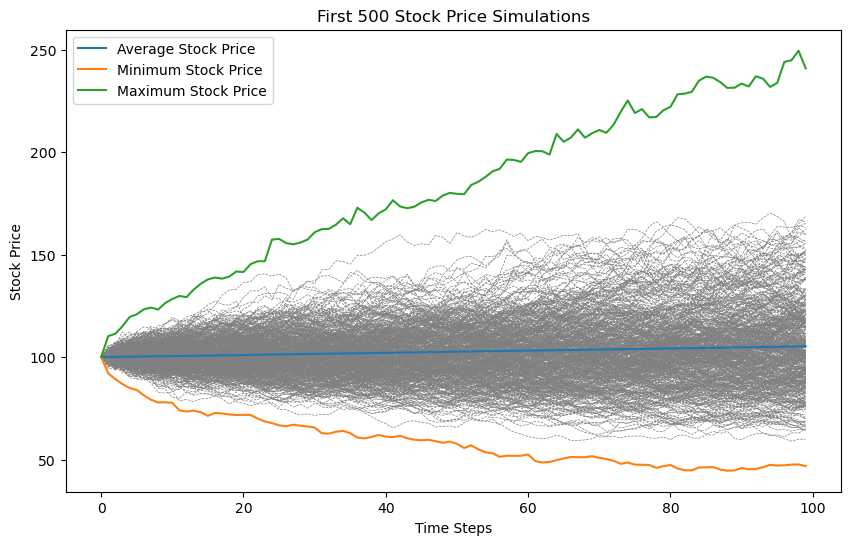

In [125]:
plt.figure(figsize=(10, 6))
for i in range(500):  # plot the first 500 paths
    plt.plot(S[i, :], color='gray', linewidth=0.5, linestyle='dashed')

# plot other functions of the stock price simulations, like average, min + max
avg_S = np.mean(S, axis=0)
min_S = np.min(S, axis=0)
max_S = np.max(S, axis=0)
plt.plot(avg_S, label='Average Stock Price')
plt.plot(min_S, label='Minimum Stock Price')
plt.plot(max_S, label='Maximum Stock Price')

plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title(f'First 500 Stock Price Simulations')
plt.legend()
plt.show()

### 5 Impact analysis of parameters $S_0,K,T-t,\sigma,r=5\%,\delta t,N$

In the following, let us investigate the impact of each of the parameters:

\begin{align*}
\text{Today's stock price } & S_0\\
\text{Strike } & K\\
\text{Time to expiry } & T - t\\
\text{Volatility } & \sigma\\
\text{Constant risk-free interest rate } & r\\
\text{Number of Monte Carlo Simulations } & N,
\end{align*}

while the other parameters are being held constant. To make things a bit easier for the following, I have grouped all previously written code together in a class that takes above set of parameters and initializes appropriate instance variables and simulates asset paths for every class instantiation.

In [93]:
class OptionPricer:
    def __init__(self, S0, K, r, t, dt, sigma, number_of_mc_paths):
        self.S0 = S0
        self.K = K
        self.r = r
        self.t = t
        self.dt = dt
        self.sigma = sigma
        self.number_of_mc_paths = number_of_mc_paths
        self.S = self.simulate_stock_price()

    def simulate_stock_price(self):
        """Simulate stock price using Euler-Maruyama method."""
        N = int(self.t / self.dt)  # number of time steps
        S = np.zeros((self.number_of_mc_paths, N))
        S[:, 0] = self.S0
        for i in range(1, N):
            dW = np.random.standard_normal(self.number_of_mc_paths)  # Brownian increment
            S[:, i] = S[:, i-1] * np.exp((self.r - 0.5 * self.sigma ** 2) * self.dt + self.sigma * np.sqrt(self.dt) * dW)  # Euler-Maruyama step
        return S

    def asian_option(self, arithmetic_avg=1, fixed_strike=1):
        """Calculate Asian call + put option prices by discounting their expected payoffs."""
        if arithmetic_avg:  # calculate arithmetic mean stock price over all simulations
            avg = np.mean(self.S, axis=1)
        else:  # calculate geometric average
            avg = gmean(self.S, axis=1)
        if fixed_strike:
            asian_call = np.exp(-self.r * self.t) * np.maximum(avg - self.K, 0)
            asian_put = np.exp(-self.r * self.t) * np.maximum(self.K - avg, 0)
        else:  # calculate the option payoffs for floating strike now
            asian_call = np.exp(-self.r * self.t) * np.maximum(self.S[:, -1] - avg, 0)
            asian_put = np.exp(-self.r * self.t) * np.maximum(avg - self.S[:, -1], 0)
        return np.mean(asian_call), np.mean(asian_put)

    def lookback_option(self, fixed_strike=1):
        """Calculate Lookback call + put option prices by discounting their expected payoffs."""
        min_S = np.min(self.S, axis=1)  # minimum stock price over all simulations
        max_S = np.max(self.S, axis=1)  # maximum stock price over all simulations
        if fixed_strike:
            lookback_call = np.exp(-self.r * self.t) * np.maximum(max_S - self.K, 0)
            lookback_put = np.exp(-self.r * self.t) * np.maximum(self.K - min_S, 0)
        else:  # calculate the option payoffs for floating strike now
            lookback_call = np.exp(-self.r * self.t) * np.maximum(self.S[:, -1] - min_S, 0)
            lookback_put = np.exp(-self.r * self.t) * np.maximum(max_S - self.S[:, -1], 0)
        return np.mean(lookback_call), np.mean(lookback_put)

    def calculate_option_prices(self):
        """Calculate the prices of different options types."""
        # Calculate option prices
        asian_fixed_call, asian_fixed_put = self.asian_option(arithmetic_avg=1, fixed_strike=1)
        asian_float_call, asian_float_put = self.asian_option(arithmetic_avg=1, fixed_strike=0)
        asian_g_fixed_call, asian_g_fixed_put = self.asian_option(arithmetic_avg=0, fixed_strike=1)
        asian_g_float_call, asian_g_float_put = self.asian_option(arithmetic_avg=0, fixed_strike=0)
        lookback_fixed_call, lookback_fixed_put = self.lookback_option(fixed_strike=1)
        lookback_float_call, lookback_float_put = self.lookback_option(fixed_strike=0)
        return asian_fixed_call, asian_fixed_put, asian_float_call, asian_float_put,\
            asian_g_fixed_call, asian_g_fixed_put, asian_g_float_call, asian_g_float_put,\
            lookback_fixed_call, lookback_fixed_put, lookback_float_call, lookback_float_put

These functions (in particular `plot_option_prices_vs_param`) will be used to plot the option prices against the parameters we wish to analyze the impact of.

In [94]:
def get_labels_for_plot(plot_all_asian_options):
    arithmetic_labels = ['Asian Arithmetic Avg.\nFixed Call', 'Asian Arithmetic Avg.\n Fixed Put',
                         'Asian Arithmetic Avg.\n Float Call', 'Asian Arithmetic Avg.\n Float Put']
    geometric_labels = ['Asian Geometric Avg.\n Fixed Call', 'Asian Geometric Avg.\n Fixed Put',
                        'Asian Geometric Avg.\n Float Call', 'Asian Geometric Avg.\n Float Put']
    lookback_labels = ['Lookback Fixed Call', 'Lookback Fixed Put', 'Lookback Float Call', 'Lookback Float Put']
    return arithmetic_labels + (geometric_labels if plot_all_asian_options else []) + lookback_labels


def plot_option_prices_vs_param(param_name, param_values, option_prices, plot_all_asian_options,
                                annotation_precision=2, log_x_axis=False):
    """Plot the option prices for different values of a parameter."""
    plt.figure(figsize=(12, 6))

    # define order of colors for the plots, so option price scatter dot has same color as the connecting line
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'rosybrown', 'darkorange', 'grey', 'lime', 'teal']
    for i, prices in enumerate(zip(*option_prices)):  # transpose option_prices list
        for value, price in zip(param_values, prices):
            plt.scatter(value, price, marker='o', color=colors[i])  # plot option price as scatter point
            # add text annotation for each point
            plt.text(value, price, f"{param_name}={str(round(value, annotation_precision))}", fontsize=8)

        # plot connecting lines for the scatter points of each option type, color=... ensures same color is used
        label_list = get_labels_for_plot(plot_all_asian_options)
        plt.plot(param_values, prices, label=label_list[i], color=colors[i])

    plt.xlabel(param_name)
    plt.ylabel('Option Price')
    plt.title(f'Option Prices vs {param_name}')
    if log_x_axis:
        plt.xscale('log')  # set x-axis to logarithmic scale
    plt.legend(loc='center left', bbox_to_anchor=(1.04, 0.5))  # legend outside of graphs
    plt.tight_layout()
    plt.show()

The following functions will be used to analyze each parameter Monte Carlo paths $N$. They have an additional optinal argument `plot_all_asian_options` that is set to `0` by default that I will discuss later.

In [128]:
def get_option_prices_to_plot(option_pricer_object, plot_all_asian_options):
    all_option_prices = list(option_pricer_object.calculate_option_prices())
    if not plot_all_asian_options:
        option_prices = all_option_prices[:4] + all_option_prices[8:]
    else:
        option_prices = all_option_prices
    return option_prices


def analyze_number_of_mc_paths(plot_all_asian_options=0):
    param_name = "N"
    param_values = [10, 30, 60, 100, 300, 500, 1000, 5000, 10000, 20000, 50000, 100000, 1000000]
    option_prices = []
    for param_value in param_values:
        op = OptionPricer(S0=100, K=100, r=0.05, t=1, dt=0.01, sigma=0.2, number_of_mc_paths=param_value)
        option_prices.append(get_option_prices_to_plot(op, plot_all_asian_options))
    plot_option_prices_vs_param(param_name, param_values, option_prices, plot_all_asian_options, log_x_axis=True)


def analyze_initial_value(plot_all_asian_options=0):
    param_name = "S0"
    param_values = np.linspace(50, 150, 10 + 1)  # equidistant list of 10 values for S0 from 50 to 150
    option_prices = []
    for param_value in param_values:
        op = OptionPricer(S0=param_value, K=100, r=0.05, t=1, dt=0.01, sigma=0.2, number_of_mc_paths=50000)
        option_prices.append(get_option_prices_to_plot(op, plot_all_asian_options))
    plot_option_prices_vs_param(param_name, param_values, option_prices, plot_all_asian_options, log_x_axis=False)


def analyze_strike(plot_all_asian_options=0):
    param_name = "K"
    param_values = np.linspace(50, 150, 10 + 1)  # equidistant list of 10 values for K from 50 to 150
    option_prices = []
    for param_value in param_values:
        op = OptionPricer(S0=100, K=param_value, r=0.05, t=1, dt=0.01, sigma=0.2, number_of_mc_paths=50000)
        option_prices.append(get_option_prices_to_plot(op, plot_all_asian_options))
    plot_option_prices_vs_param(param_name, param_values, option_prices, plot_all_asian_options)

    
def analyze_risk_free_rate(plot_all_asian_options=0):
    param_name = "r"
    param_values = np.linspace(0, 0.1, 10 + 1)  # an equidistant list of 10 values for r from 0% to 10%
    option_prices = []
    for param_value in param_values:
        op = OptionPricer(S0=100, K=100, r=param_value, t=1, dt=0.01, sigma=0.2, number_of_mc_paths=50000)
        option_prices.append(get_option_prices_to_plot(op, plot_all_asian_options))
    plot_option_prices_vs_param(param_name, param_values, option_prices, plot_all_asian_options)


def analyze_time_to_expiry(plot_all_asian_options=0):
    param_name = "t"
    param_values = np.linspace(0.01, 5, 10 + 1)  # equidistant list of 10 values for t (time to expiry) from 0 to 5 years
    option_prices = []
    for param_value in param_values:
        op = OptionPricer(S0=100, K=100, r=0.05, t=param_value, dt=0.01, sigma=0.2, number_of_mc_paths=50000)
        option_prices.append(get_option_prices_to_plot(op, plot_all_asian_options))
    plot_option_prices_vs_param(param_name, param_values, option_prices, plot_all_asian_options, annotation_precision=1)


def analyze_time_step(plot_all_asian_options=0):
    param_name = "dt"
    param_values = [0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1]
    option_prices = []
    for param_value in param_values:
        op = OptionPricer(S0=100, K=100, r=0.05, t=1, dt=param_value, sigma=0.2, number_of_mc_paths=50000)
        option_prices.append(get_option_prices_to_plot(op, plot_all_asian_options))
    plot_option_prices_vs_param(param_name, param_values, option_prices, plot_all_asian_options, annotation_precision=4, log_x_axis=True)


def analyze_volatility(plot_all_asian_options=0):
    param_name = "sigma"
    param_values = np.linspace(0.01, 1, 10 + 1)  # an equidistant list of 10 values for sigma from 1% to 100%
    option_prices = []
    for param_value in param_values:
        op = OptionPricer(S0=100, K=100, r=0.05, t=1, dt=0.01, sigma=param_value, number_of_mc_paths=50000)
        option_prices.append(get_option_prices_to_plot(op, plot_all_asian_options))
    plot_option_prices_vs_param(param_name, param_values, option_prices, plot_all_asian_options)

#### 5.1 Impact analysis of number of Monte Carlo paths $N$

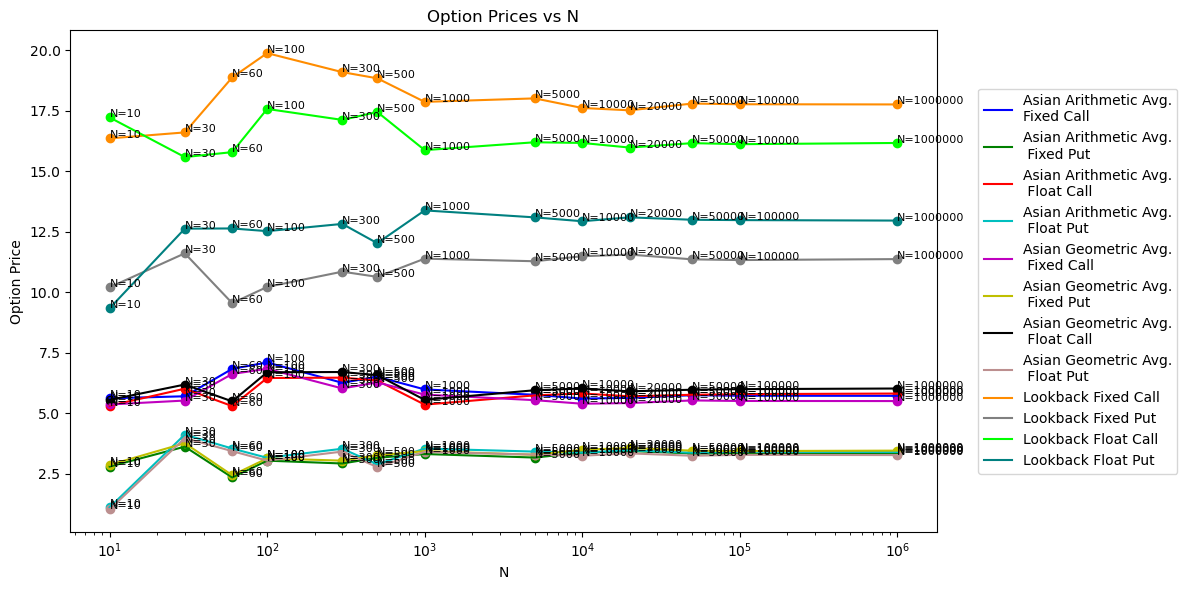

In [96]:
analyze_number_of_mc_paths(plot_all_asian_options=1)

We can see that the option prices start off instable if the number of Monte Carlo paths is chosen low at $N<1000$. As $N$ increases (note that x-axis scales logarithmically), the option prices become more stable and evidently seem to converge somewhat at around $N=10000$, although for certain options like the Lookback type options, one can still see some price changes from $N=20000$ to $N=50000$. Therefore, for further testing, we will stick with the initially assumed $N=50000$. (I wanted to analyze this parameter first to see if one could improve performance without giving up option price accuracy.)

The instable numerical behavior for $N<1000$ is not unexpected because the error source stemming from number of simulations is of order $\mathcal{O}(N^{-0.5})$ [1] which is larger, the smaller the value of $N$.

#### 5.2 Impact analysis of initial stock value $S_0$

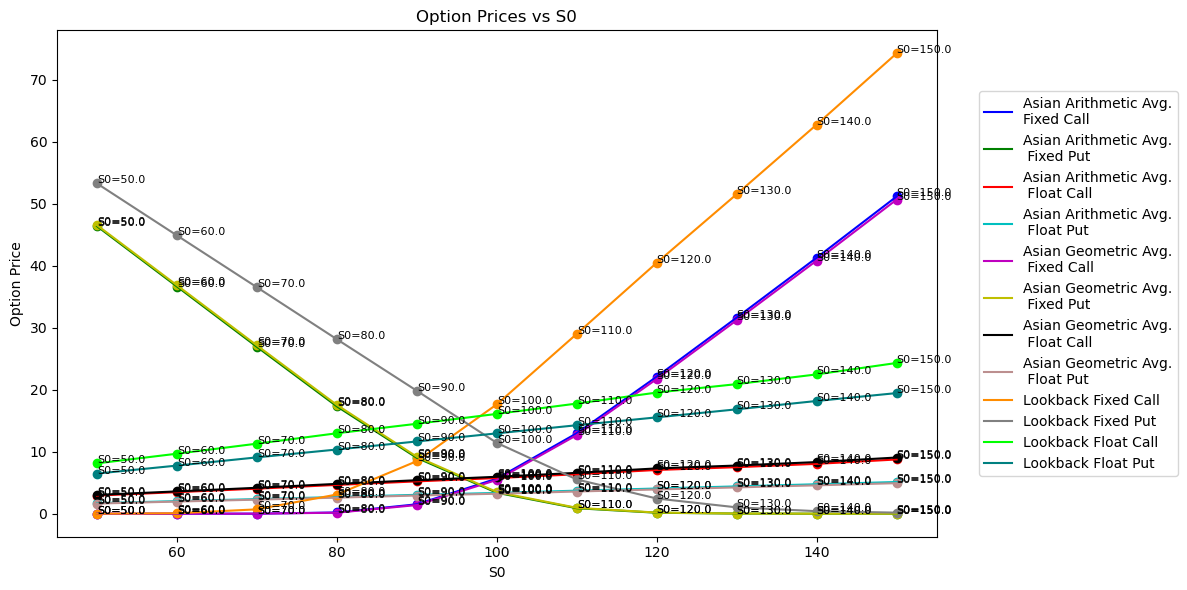

In [99]:
analyze_initial_value(plot_all_asian_options=1)

It can be observed that as $S_0$ increases, the Asian and Lookback option with fixed strike call options increase. This is due to the fact that with strike value $K=100$ being held constant, call options tend to go from out-of-the-money (in connection with lower values of $S_0$) to in-the-money (in connection with increasing values of $S_0$) for both Asian as Lookback fixed strike call options, since both the average as well as the maximum of the asset price tend to increase as the initial value of the stock $S_0$ increases. The increasing intrinsic value (value of the option if executed immediately, $\max\left(S-K,0\right)$ for call options) makes the options more profitable and therefore more expensive.

The exact opposite is true for Asian and Lookback fixed strike put options. Those decrease in option value with increasing values of $S_0$, since they describe the seller's perspective.

The case of floating strike options is more interesting, as *both* put and call options increase in value as $S_0$ increases, for both Asian and Lookback options. Recall that floating strike options have no dependence on the fixed strike value $K$, so above argument for Asian and Lookback fixed strike call options with fixed $K=100$ does not apply anymore. In fact, the "strike" is now given as a function of the stock price over a time interval. But this strike function again depends on $S_0$ and tends to increase as $S_0$ increases. It therefore makes sense that also the option value (for all functions average, maximum & minimum) will in increase of proportional order as $S_0$ increases, hence the positive linear dependence of the option price with respect to $S_0$ for all the considered option types.

We also observe that for the Asian options, the arithmetic and geometric mean type options do not differ significantly from one another in pricing. We will therefore discard the geometric mean-style option in the following discussion and only plot and analyze arithmetic mean-style Asian options. This should also make the plot more readable. This was also why I added the optional argument `plot_all_asian_options` in the `analyze_...` functions above. For the parameter $S_0$, the reduced graph would look like this:

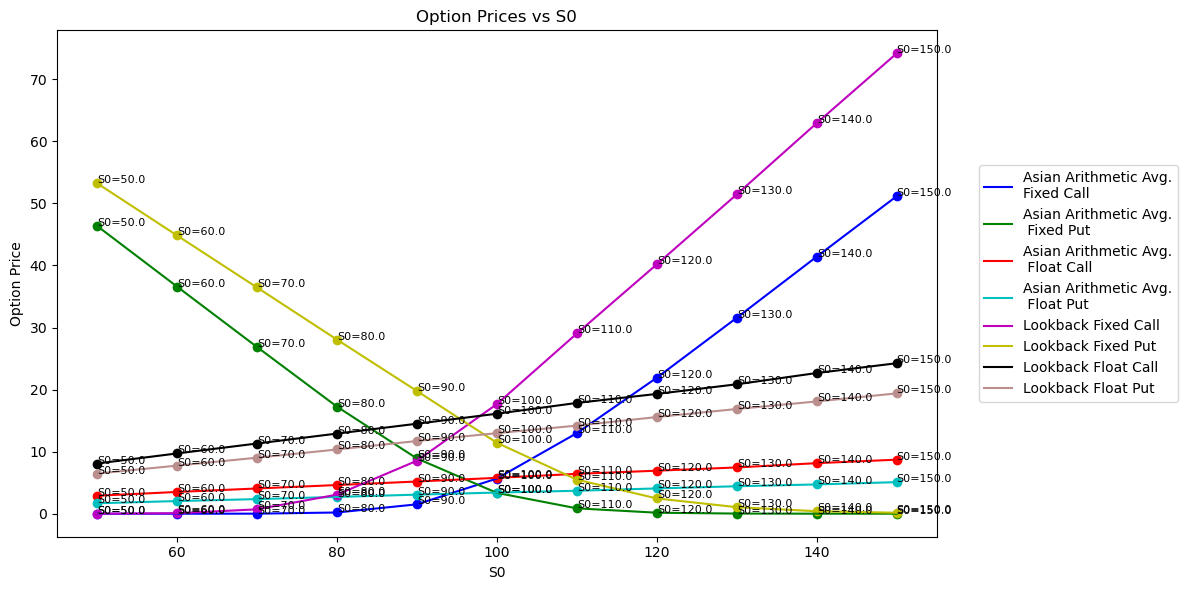

In [101]:
analyze_initial_value()

#### 5.3 Impact analysis of strike parameter $K$

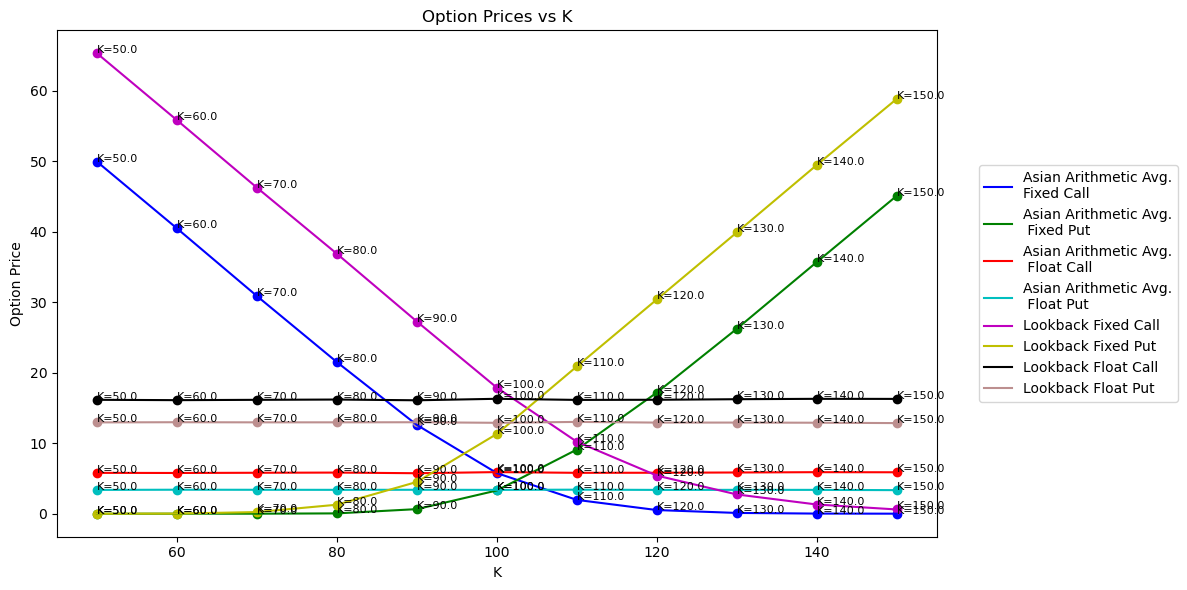

In [108]:
analyze_strike()

First, we can nicely see how floating options are independent of strike $K$ since this is not a parameter in their payoff definition.

For fixed strike options, it can be observed that call option tends to decrease in value as the strike $K$ increases. Increasing $K$ has the opposite effect of increasing $S_0$ (see also above in section 5.2), because the in-the-money options from section 5.2 will now become out-of-the-money, as their expected payoff $\max(A-K, 0)$ for Asian option ($\max(M-K, 0)$ for Lookback option) tends to 0 for increasing values of $K$.

The opposite can be observed for put fixed strike options that now increase in option price as strike value $K$ increases.

#### 5.4 Impact analysis of risk-free rate $r$

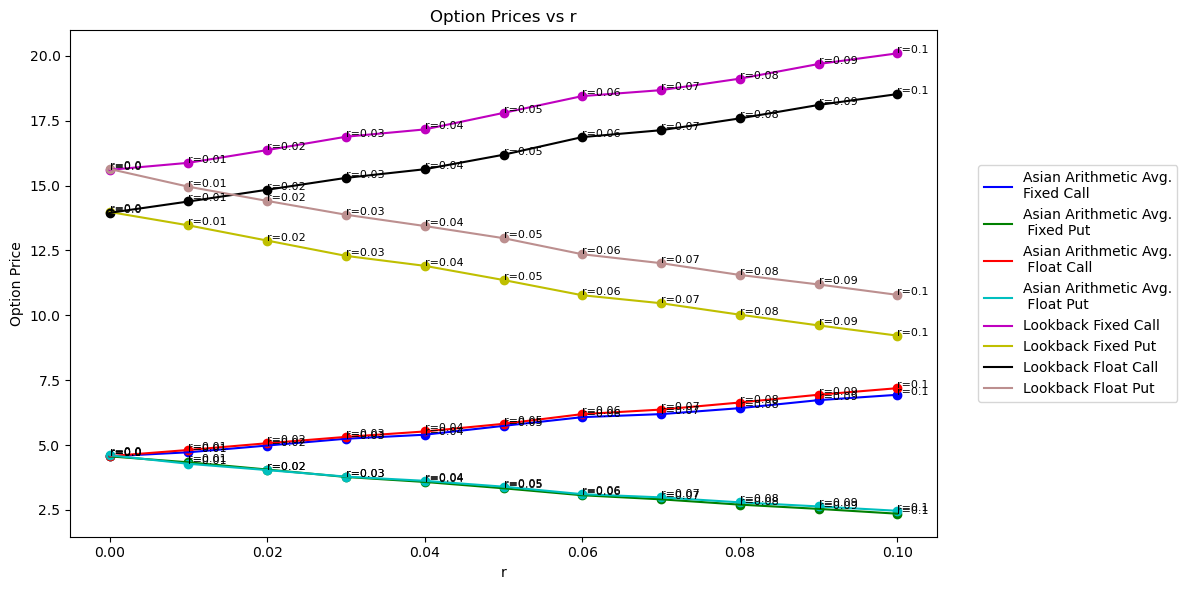

In [117]:
analyze_risk_free_rate()

We see that call option prices increase as the risk-free rate $r$ increases, while put options similarly decrease at the same time.

Notice the left-most point at $r=0$ where put and call option prices of the same type coincide: Since $r$ impacts only the drift of the stochastic process of the stock price following a GBM

$$dS_t = rS_t dt + \sigma S_t dW_t$$

under risk-neutrality, $r=0$ implies an underlying asset paths $$dS_t = \sigma S_t dW_t$$ will behave exactly like a Wiener process with mean $S_0$ and equal probabilities to move up or down in the next time step, i.e. the underlying stock process has no clear upward or downward trend.

The equality or put and call prices at $r=0$ can also be regarded as a consequence of Put-Call parity for call option value $C$ at strike $K$, put option value $P$ at strike $K$:

$$C-P=S_0-PV(K)=S_0-\exp(-rt)K.$$

For $r=0$, it folows that $C-P=S_0-K$ and in our example, with $S_0=K=100$, it follows that $C=P$. For increasing values of $r$, the difference between $S_0$ and $PV(K)=\exp(-rt)K$ and therefore the difference of $C-P$ will increase. What looks like a linear increase in above graph is actually only approximately linear for small values of $r$ (in the example above ranging from 0 to 10%). Plotting again above plot for much larger values of $r$ from -1 to 1 in equidistant intervals yields a clearly non-linear behavior with respect to $r$.

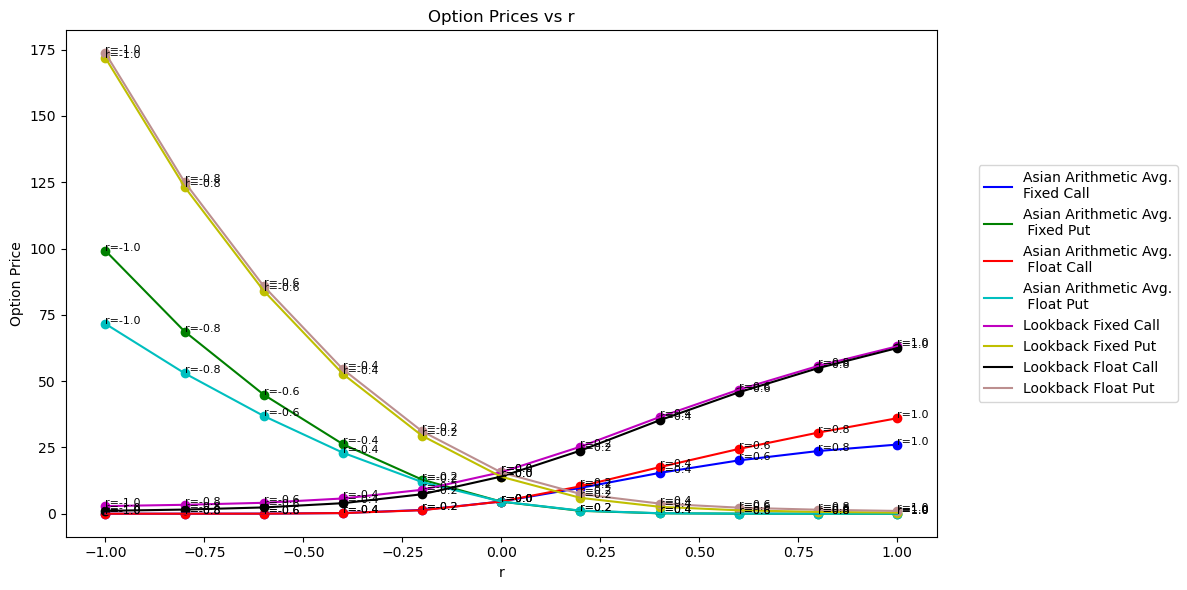

In [122]:
param_name = "r"
param_values = np.linspace(-1, 1, 10 + 1)  # an equidistant list of 10 values for r from 0% to 10%
option_prices = []
for param_value in param_values:
    op = OptionPricer(S0=100, K=100, r=param_value, t=1, dt=0.01, sigma=0.2, number_of_mc_paths=50000)
    option_prices.append(get_option_prices_to_plot(op, plot_all_asian_options=0))
plot_option_prices_vs_param(param_name, param_values, option_prices, plot_all_asian_options=0)

#### 5.5 Impact analysis of time to expiry $T-t$

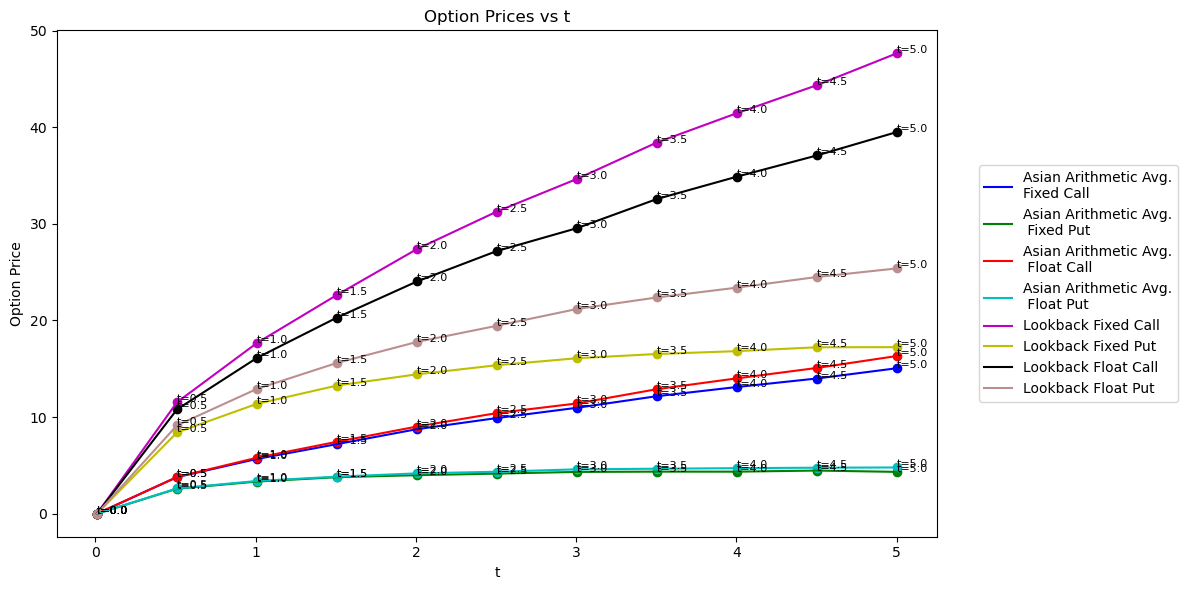

In [113]:
analyze_time_to_expiry()

In this plot, we conclude that regardless of option type (call or put, Lookback or Asian, fixed or floating strike convention), the option value increases with higher time to maturity. Intuitively, the higher option prices with longer time-to-maturity's makes sense because the options have more time to become in-the-money and therefore profitable.

#### 5.6 Impact analysis of time step $\delta t$

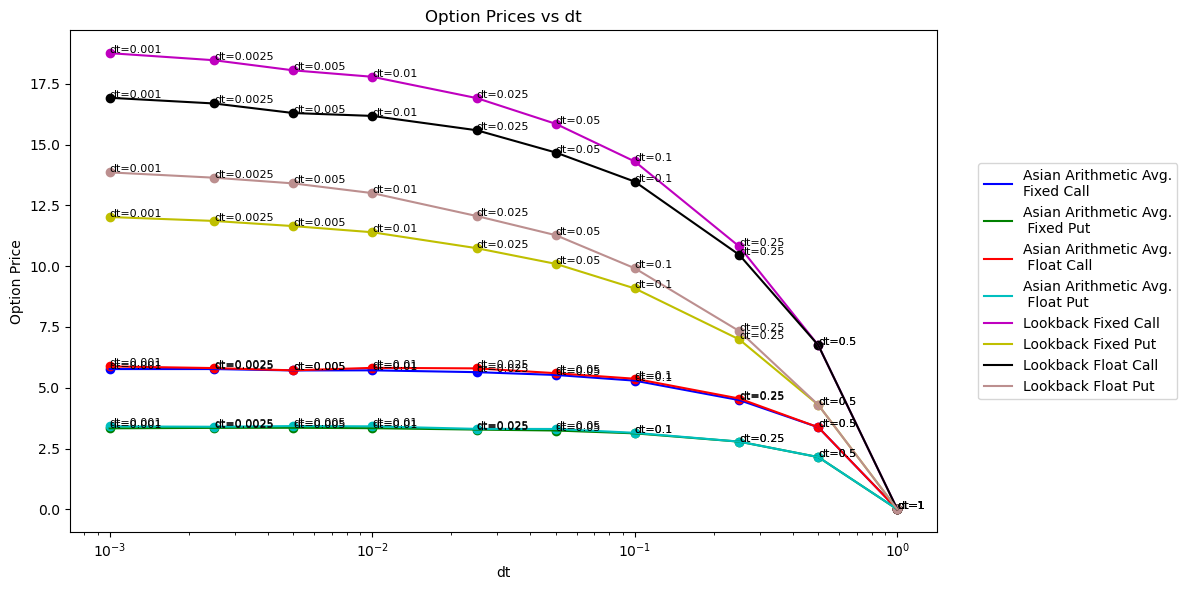

In [114]:
analyze_time_step()

Firstly, remember that the time step $\delta t$ in Euler-Maruyama method represents the length of the time intervals used in the discretization of the continuous-time model. This implies that a very low number for $\delta t$ will discretize the process the best, as the continuous time limit is obtained by $\delta t\rightarrow 0$. It has also been explained in the lecture about Numerical Methods [1] that the Monte Carlo error induced from time step $\delta t$ is of order $$.

However, as with all numerical implementations, there is a sweet spot for the discretization parameter, where one must consider:
* Performance: Run-time of algorithm will decrease (i.e. become more performant) down as $\delta t$ increases.
* Numerical stability: The possibility of floating-point arithmetic errors and numerical instability w.r.t. to numerical noise building up increases when $\delta t$ decreases.
* Option price accuracy: increases when $\delta t$ decreases, because the underlying stock price needs to be simulated more frequently if the time interval is chosen to be smaller.

In our example, we can see that Asian option prices start to become quite stable around $\delta t=0.01=100$ time intervals to discretize 1 year time-to-maturity or $\delta t=.025=40$ time intervals. However, for Lookback options, it seems that even greater accuracy could maybe be achieved for even smaller values for of $\delta t$, since the curves for the Lookback options are still not flat for small values of $\delta t$.

#### 5.7 Impact analysis of volatility $\sigma$

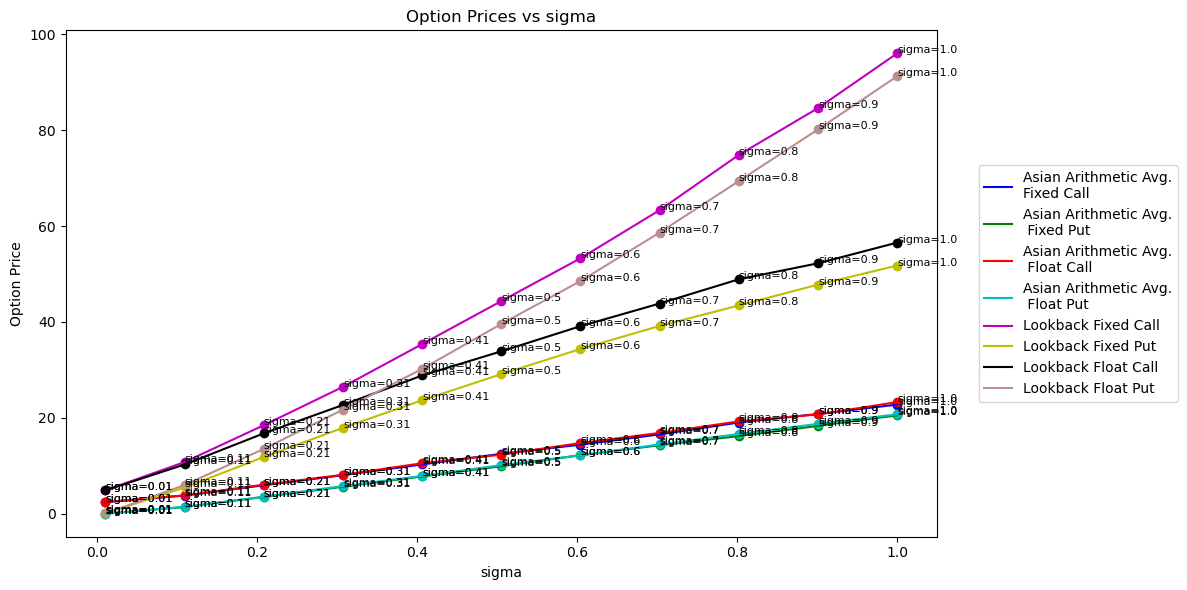

In [129]:
analyze_volatility()

It can be observed that for all option types, the option price increases as the volatility $\sigma$ increases. Intuitively, this is due to the face that higher volatility is equivalent to higher uncertainty about the underlying stock price movements and therefore, higher uncertainty in the derivative pricing on such stocks.

Mathematically, it can be seen that $\sigma$ proportionally impacts the diffusion (“randomness”) of the underlying asset path modeled as geometric Brownian motion via
$$dS_t = rS_t dt + \sigma S_t dW_t.$$
Therefore, increasing $\sigma$ while holding all other parameters constant will increase the potential deviation of $S_t$ from its mean path indicating greater price uncertainty and therefore higher risk.

For example, for the Asian put option with fixed strike, higher volatility increases the probability that the average price will be below the strike price, therefore increasing the expected payoff. At the same time, it also increases the probability that the average price will be above the strike price, therefore increasing the expected payoff for the analogous call option.

Since all discussed option prices depend significantly on the trajectory of the underlying asset price, an increasing volatility – implying broader distributions of the underlying asset’s possible trajectories – must have an increasing impact on all option prices.

### 6 Final conclusion

We observe that the price depends differently on each of the parameters, implying that a broad understanding of all market and model parameters is required to understand Monte Carlo option pricing models to its fullest. We assumed that the stock follows a geometric Brownian motion movement

$$dS_t = rS_tdt+\sigma S_tdW_t$$

under the risk-neutrality and modeled the stock price process using a Euler-Maruyama discretization method (Monte Carlo pricing method). We then proceeded to price Asian and Lookback options in different variants.

It can be directly derived from the geometric Brownian motion assumption that higher volatility $\sigma$ will lead to a greater spectrum in potential future stock prices, increasing the prices of all options consistently by increasing the probability of profitable values for their expected payoffs, since it enhances both the potential up-side for calls as well as the potential down-side for puts (section 5.7). The assumption of geometric Brownian asset paths also explains how the risk-free rate $r$ influences option prices through over the drift component of the stock price and the discounting of option payoffs. A positive drift increases the expected payout for call options as their potential payoffs become larger, while negative or low drift conditions profit more buyers of put options (section 5.4). Since an option's time value offers more opportunities for the option to become profitable, higher time to maturity $T-t$ also results in higher option prices consistently (section 5.5).

Moreover, the parameters of initial stock price $S_0$ or strike price of $K$ display dynamic influences on option valuations. It was demonstrated and explained how higher initial stock prices tend to increase the value of call options (section 5.2), since they will be more likely to be in-the-money, while simultaneously decreasing the value of put options. Conversely, the effect of strike prices exhibits the opposite behavior of the former (section 5.3), since now, $S_0$ is held constant while the exercise price $K$ increases.

Last but not least, choosing appropriate numerical model parameters for time step length $\delta t$ (section 5.6) as well as the number of Monte Carlo paths $N$ (section 5.1) are integral to our analysis and their adequateness should be tested in any numerical implementation.

Overall, this analysis illustrates the complex interactions between different parameters in option pricing. Understanding how each parameter affects option valuation can significantly enhance trading and risk management, especially for more exotic payoffs such as Asian or Lookback options.

## References

* [1]: JA243.4: Lecture Notes on Numerical Methods by Dr. Riaz Ahmad, CQF Faculty, Head of Faculty
* [2]: JA24 Monte Carlo Simulation: CQF Python Labs on Monte Carlo Simulation by Kannan Singaravelu
* [3]: Willmott, Paul - _Paul Willmott on Quantitative Finance_, Second Edition, Volume 2, p. 427-452, Wiley, 2006
* [4]: JA243.5: Lecture Notes on Exotic Options by Dr. Riaz Ahmad, CQF Faculty, Head of Faculty
* [5]: [Matplotlib documentation](https://matplotlib.org)
